<h1 style="color: orange;">Logistic Regression Model for SBA Financial Data</h1>

<h2 style="color: green;">Introduction</h2>
<p style="color: gray;">
In this notebook, we build and evaluate a <strong>Logistic Regression</strong> model for the SBA Financial dataset. Logistic Regression is a well‑known linear model for binary classification. Because it is sensitive to feature scaling, we include a <em>StandardScaler</em> in our preprocessing pipeline. 
</p>

<h2 style="color: green;">Objectives</h2>
<ul>
  <li style="color: gray;">Preprocess the data by imputing missing values and applying target encoding on high-cardinality categorical features.</li>
  <li style="color: gray;">Construct a pipeline that scales features and fits a Logistic Regression model.</li>
  <li style="color: gray;">Optimize the model’s hyperparameters using a two-stage tuning approach: first a randomized search, followed by a refined grid search.</li>
  <li style="color: gray;">Evaluate model performance with metrics such as ROC AUC, the confusion matrix, and a detailed classification report.</li>
</ul>

<h2 style="color: green;">Dataset</h2>
<p style="color: gray;">
The dataset contains a mix of numerical and categorical features. High-cardinality categorical features are handled by target encoding, and missing values are imputed using the most frequent value. This ensures that the data fed to our Logistic Regression model is properly preprocessed.
</p>

<h2 style="color: green;">Let's Get Started!</h2>


<h3 style="color: Gray;"> 📌 1. Import libraries</h3>

In [18]:
#Data Manipulation
import os
import pickle
import pandas as pd
import numpy as np

#Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

#Data modelization
from sklearn.model_selection import train_test_split, RandomizedSearchCV,GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from category_encoders import TargetEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix,roc_curve, auc,ConfusionMatrixDisplay
import shap


<h3 style="color: Gray;"> 📌 2. Load Data & Define Target </h3>

In [2]:
#Loading my dataset 
with open("/home/utilisateur/Documents/Loan_Projet_Brief/Brief_Loan_Project/data/exp_data.pkl", "rb") as f:
    df = pickle.load(f, fix_imports=True)
    
print(df.head(2))
df.info()


  State    Zip BankState  ApprovalFY  Term  NoEmp  NewExist  CreateJob  \
0    IN  47711        OH        1997    84      4       1.0          0   
1    IN  46526        IN        1997    60      2       1.0          0   

   RetainedJob  FranchiseCode  UrbanRural  RevLineCr  LowDoc  \
0            0              0           0        0.0     1.0   
1            0              0           0        0.0     1.0   

   DisbursementGross  MIS_Status   GrAppv ApprovalMonth NAICS_CODE  
0            60000.0           0  60000.0             2         45  
1            40000.0           0  40000.0             2         72  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 899164 entries, 0 to 899163
Data columns (total 18 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   State              899162 non-null  object 
 1   Zip                899164 non-null  object 
 2   BankState          897598 non-null  object 
 3   ApprovalFY      

In [3]:
#  Define a helper function to convert binary columns
def convert_binary(X):
    X = X.copy()
    binary_cols = ["RevLineCr", "LowDoc", "NewExist"]
    for col in binary_cols:
        if col in X.columns:
            X[col] = X[col].astype(int)
    return X

In [ ]:
# --- Data Preparation ---
target = "MIS_Status"
X = df.drop(columns=[target])
y = df[target]

# Columns to impute 
cols_to_impute = ['State','RevLineCr', 'LowDoc', 'BankState', 'NewExist']
imputer = SimpleImputer(strategy='most_frequent')
X[cols_to_impute] = imputer.fit_transform(X[cols_to_impute])
# Assuming X is your feature DataFrame
X = convert_binary(X)

# Then split your data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, stratify=y, random_state=42
)

# Identify categorical columns (for target encoding)
cat_cols = X.select_dtypes(include=["object", "category"]).columns.tolist()

<h3 style="color: Gray;"> 📌 3. RandomizedSearchCV </h3>

In [9]:
pipeline_lr = Pipeline([
    #("imputer", SimpleImputer(strategy="most_frequent")),
    ("target_encoder", TargetEncoder(cols=cat_cols, smoothing=0.3)),
    ("scaler", StandardScaler()),
    ("classifier", LogisticRegression(solver="lbfgs", max_iter=1000, random_state=42))
])
 #--- Define Hyperparameter Distribution for Randomized Search ---
# For Logistic Regression, we mainly tune the regularization strength 'C'
param_dist_lr = {
    "classifier__C": np.logspace(-3, 3, 50),# testing values between 0.001 and 1000
      "classifier__penalty": ['l1', 'l2']  
}

# --- Run RandomizedSearchCV ---
rs_lr = RandomizedSearchCV(
    pipeline_lr,
    param_distributions=param_dist_lr,
    n_iter=30,      # You can adjust this for speed
    cv=5,
    scoring="roc_auc",
    random_state=42,
    n_jobs=-1,
    verbose=1
)

rs_lr.fit(X_train, y_train)

print("Best parameters from RandomizedSearchCV for Logistic Regression:")
print(rs_lr.best_params_)

# --- Evaluate the Best Model from Randomized Search ---
best_lr_rs = rs_lr.best_estimator_
y_pred_lr = best_lr_rs.predict(X_test)
y_pred_proba_lr = best_lr_rs.predict_proba(X_test)[:, 1]
auc_score_lr = roc_auc_score(y_test, y_pred_proba_lr)
report_lr = classification_report(y_test, y_pred_lr)
cm_lr = confusion_matrix(y_test, y_pred_lr)

print(f"AUC Score: {auc_score_lr:.4f}")
print(report_lr)
print("Confusion Matrix:")
print(cm_lr)


Fitting 5 folds for each of 30 candidates, totalling 150 fits


/home/utilisateur/Documents/Loan_Projet_Brief/Brief_Loan_Project/.venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
90 fits failed out of a total of 150.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
90 fits failed with the following error:
Traceback (most recent call last):
  File "/home/utilisateur/Documents/Loan_Projet_Brief/Brief_Loan_Project/.venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/utilisateur/Documents/Loan_Projet_Brief/Brief_Loan_Project/.venv/lib/python3.12/site-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwarg

Best parameters from RandomizedSearchCV for Logistic Regression:
{'classifier__penalty': 'l2', 'classifier__C': 0.21209508879201905}
AUC Score: 0.8370
              precision    recall  f1-score   support

           0       0.86      0.97      0.92     74135
           1       0.70      0.28      0.40     15782

    accuracy                           0.85     89917
   macro avg       0.78      0.63      0.66     89917
weighted avg       0.84      0.85      0.83     89917

Confusion Matrix:
[[72195  1940]
 [11311  4471]]


<h3 style="color: Gray;"> 📌 4. GridSearchCV  </h3>

In [13]:

# Extract best parameters from the randomized search
best_params_lr = rs_lr.best_params_
print("Randomized search best parameters:", best_params_lr)

# Construct a refined parameter grid around the best 'C' value.
# We'll only use the best penalty from the randomized search.
param_grid_lr = {
    "classifier__C": [best_params_lr["classifier__C"] * 0.8,
                        best_params_lr["classifier__C"],
                        best_params_lr["classifier__C"] * 1.2],
    "classifier__penalty": [best_params_lr["classifier__penalty"]]
}

print("Grid search parameter grid:")
print(param_grid_lr)

gs_lr = GridSearchCV(
    pipeline_lr,
    param_grid=param_grid_lr,
    cv=5,
    scoring="roc_auc",
    n_jobs=-1,
    verbose=1
)

gs_lr.fit(X_train, y_train)

print("Best parameters from GridSearchCV for Logistic Regression:")
print(gs_lr.best_params_)

# Evaluate the best estimator from grid search on the test set.
best_lr_gs = gs_lr.best_estimator_
y_pred_lr_gs = best_lr_gs.predict(X_test)
y_pred_proba_lr_gs = best_lr_gs.predict_proba(X_test)[:, 1]
auc_score_lr_gs = roc_auc_score(y_test, y_pred_proba_lr_gs)
report_lr_gs = classification_report(y_test, y_pred_lr_gs)
cm_lr_gs = confusion_matrix(y_test, y_pred_lr_gs)

print(f"AUC Score after Grid Search: {auc_score_lr_gs:.4f}")
print(report_lr_gs)
print("Confusion Matrix after Grid Search:")
print(cm_lr_gs)


Randomized search best parameters: {'classifier__penalty': 'l2', 'classifier__C': 0.21209508879201905}
Grid search parameter grid:
{'classifier__C': [0.16967607103361526, 0.21209508879201905, 0.25451410655042284], 'classifier__penalty': ['l2']}
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best parameters from GridSearchCV for Logistic Regression:
{'classifier__C': 0.25451410655042284, 'classifier__penalty': 'l2'}
AUC Score after Grid Search: 0.8370
              precision    recall  f1-score   support

           0       0.86      0.97      0.92     74135
           1       0.70      0.28      0.40     15782

    accuracy                           0.85     89917
   macro avg       0.78      0.63      0.66     89917
weighted avg       0.84      0.85      0.83     89917

Confusion Matrix after Grid Search:
[[72195  1940]
 [11311  4471]]


<h3 style="color: Gray;"> 📌 5. Exporting our model </h3>

In [14]:
export_dir = '/home/utilisateur/Documents/Loan_Projet_Brief/Brief_Loan_Project/src/models/'
os.makedirs(export_dir, exist_ok=True)  # create the directory if it doesn't exist

# Assuming your best grid model is stored in best_catboost_gs:
file_path = os.path.join(export_dir, 'logistic_regression_best_grid_model.pkl')
with open(file_path, "wb") as f:
    pickle.dump(best_lr_gs, f)
print(f"Exported grid model to {file_path}")

Exported grid model to /home/utilisateur/Documents/Loan_Projet_Brief/Brief_Loan_Project/src/models/logistic_regression_best_grid_model.pkl


<h3 style="color: Gray;"> 📌 6. DataViz of our model </h3>

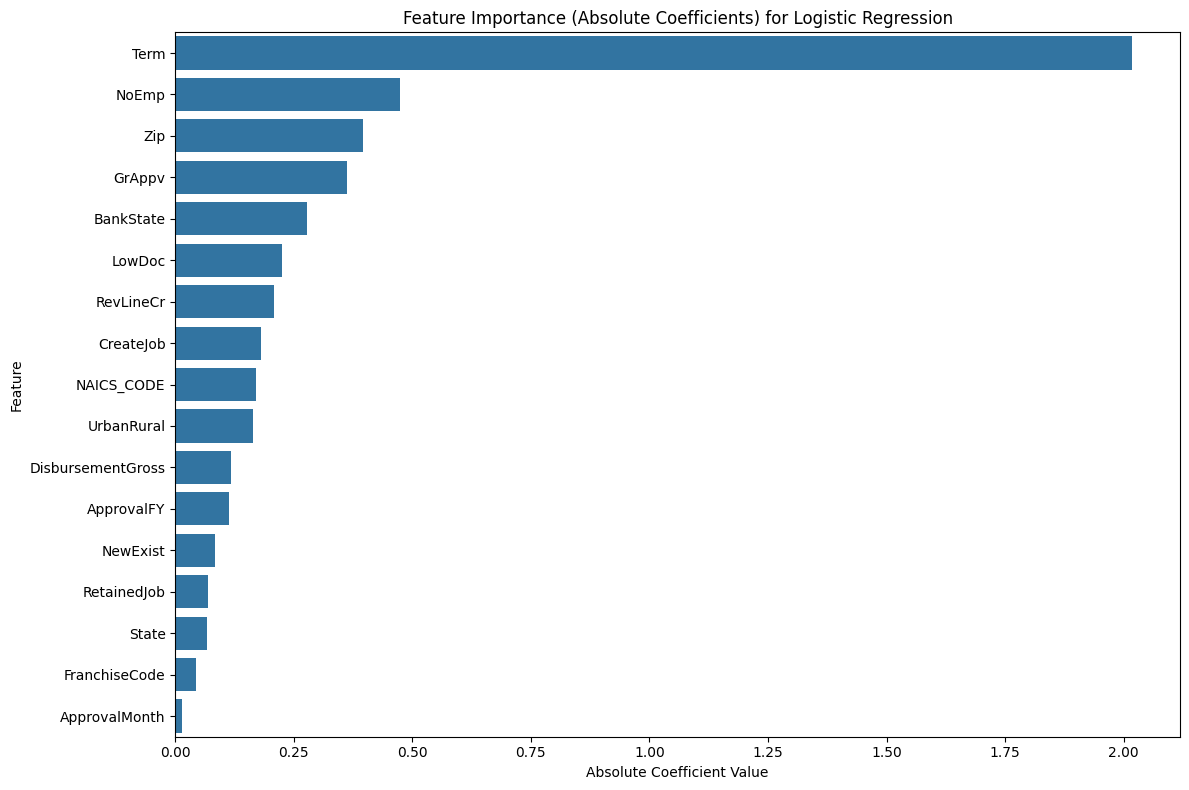

In [ ]:
#############################################  Feature Importance ####################################################


# Extract the Logistic Regression classifier from the pipeline
classifier = best_lr_gs.named_steps["classifier"]

# Get the coefficients (for binary classification, shape is (1, n_features))
coefs = classifier.coef_[0]

# Assuming the target encoder preserves the original feature names,
# we can use X_train.columns for our feature names.
feature_names = X_train.columns

# Create a DataFrame with the coefficients and their absolute values as "importance"
feat_imp_df = pd.DataFrame({
    "Feature": feature_names,
    "Coefficient": coefs,
    "Importance": np.abs(coefs)
}).sort_values(by="Importance", ascending=False)

# Plot the top features by importance
plt.figure(figsize=(12, 8))
sns.barplot(x="Importance", y="Feature", data=feat_imp_df)
plt.title("Feature Importance (Absolute Coefficients) for Logistic Regression")
plt.xlabel("Absolute Coefficient Value")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

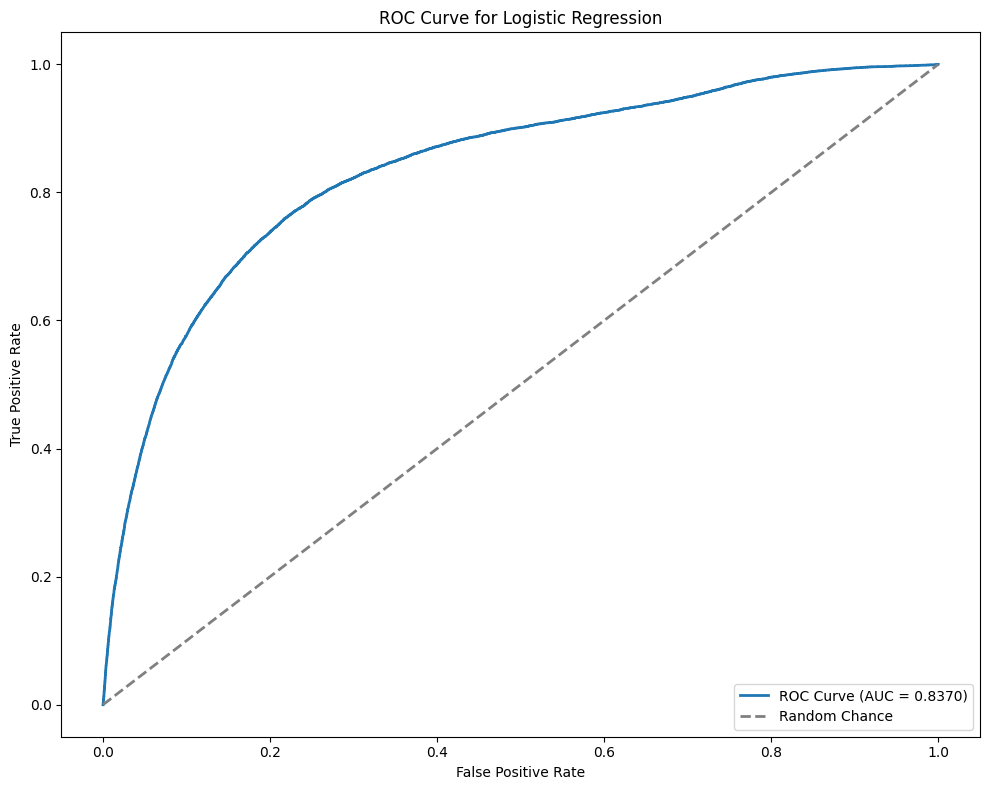

In [ ]:
#############################################  Roc Curve ####################################################
# Get predicted probabilities for the positive class
y_pred_proba = best_lr_gs.predict_proba(X_test)[:, 1]

# Compute false positive rate, true positive rate, and thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, lw=2, label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--', label='Random Chance')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Logistic Regression')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()


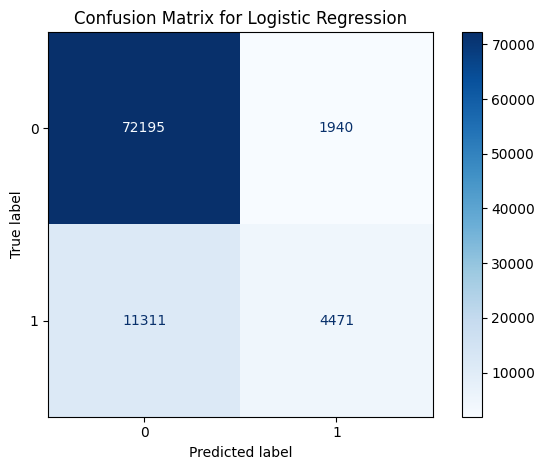

In [ ]:
#############################################  Roc Curve ####################################################

# Predict on the test set using the best Logistic Regression model from grid search
y_pred = best_lr_gs.predict(X_test)

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Create a display object and plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix for Logistic Regression")
plt.tight_layout()
plt.show()

100%|██████████| 100/100 [01:50<00:00,  1.10s/it]


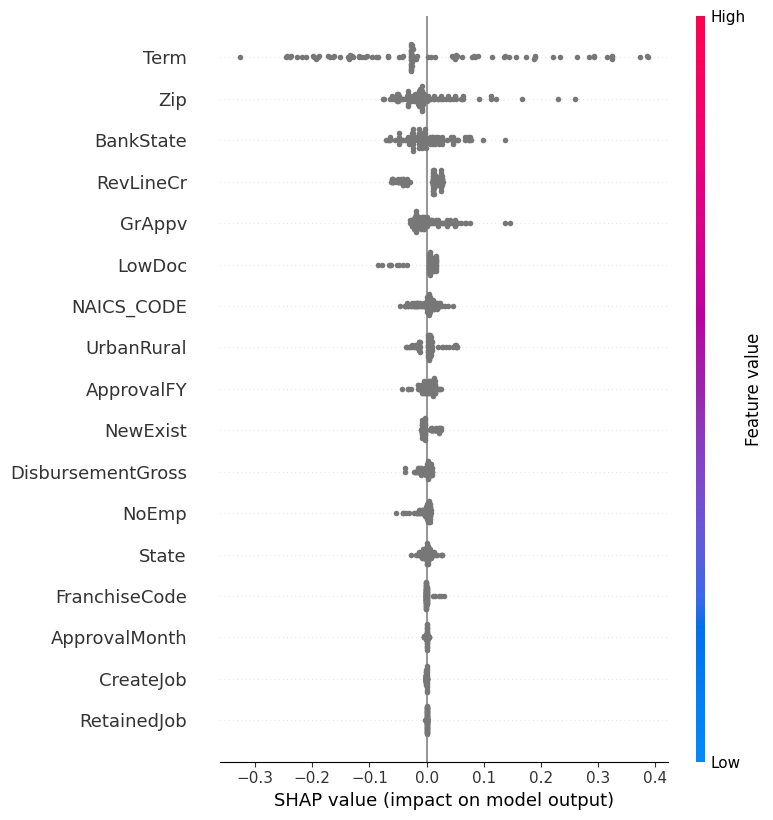

In [ ]:

#############################################  Shao Values ####################################################

# Create a wrapper function to be able to get the graphic for this model 

def model_predict(data):
    # data is passed as a numpy array by the explainer,
    # so convert it to a DataFrame using the columns from X_train.
    data_df = pd.DataFrame(data, columns=X_train.columns)
    # Return predicted probabilities for the positive class.
    return best_lr_gs.predict_proba(data_df)[:, 1]

# Use a small background sample (as a numpy array) for the KernelExplainer.
background = X_train.sample(100, random_state=42).values

# Initialize the KernelExplainer with the wrapper function.
explainer = shap.KernelExplainer(model_predict, background)

# Choose a small sample of X_test to explain (again converting to numpy array).
X_test_sample = X_test.sample(100, random_state=42).values

# Compute SHAP values. For binary classification, KernelExplainer returns a single array.
shap_values = explainer.shap_values(X_test_sample)

# Convert the sample back to a DataFrame for plotting.
X_test_sample_df = pd.DataFrame(X_test_sample, columns=X_train.columns)

# Plot a summary plot for the positive class.
shap.summary_plot(shap_values, X_test_sample_df, feature_names=X_train.columns)

